In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)

def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes", vert=False)

<a id='top'></a>

# Pots of Gold

1. here's your product wheel and the loss in transition sheets from your random
    production plan to one that is optimized. Potentially run through
    monte carlo
    * traveling salesman

# Hypotheses
* we have some anomalies in the data
    1. [unusual Next Color Code](#color)
    
* can we use the sequence of order numbers to isolate those for which we had failed transitions 
  (i.e. we gave up) and determine the relationship between transition attempts and fail rate?
    1. [fail rates](#fail)

    

    

* ### Transition Distributions
    1. [distributions](#dist) Let's fill in the cells in the matrix
    1. [fraction of transitions explained](#terminate)  When should we terminate a bad transition?
    3. [sorted boxplots](#sorted)
    2. are we learning as we do the transition more often? [median transition sheets vs number of transits](#transits)


[combined data](#combinations)

* if we combine with **family labels** what are the transition characteristics for (#2)
   
    1. inter-family transitions
    2. intra-family transitions
    3. inter-subfamily transitions
    4. intra-subfamily transitions
    5. where are we having the most operational upsets in terms of product/family/subfamily


* if we combine with **scheduling data**
    1. what transitions are being scheduled today and do we have transition data for them


* combined with **downtime data**
    1. what is the relationship between products on the line and downtime

In [11]:
# read in the dataset, removed empty columns for edgars orginial excel
df = pd.read_excel('../data/OrderColorTransitionsReport 1_1_17 - 4_22_19.xlsx',
              header=205, usecols=[0,1,4,5,7,8,9,11,12])
df.head()

Cast Order Color  Next Cast Order Next Color Code      Cast Start  \
0    11570714    1M         11569110              CW  08/02/17 15:13   
1    11570714    1M         11569110              CW  08/02/17 16:00   
2    11570714    1M         11569110              CW  08/02/17 20:50   
3    11570714    1M         11569110              CW  08/03/17 15:15   
4    11570714    1M         11569110              CW  08/03/17 20:28   

    Cast End Time Total Sheets AGrade Sheets Transition Sheets  
0  08/02/17 15:54          103             1               124  
1  08/02/17 16:39           97           NaN               109  
2  08/02/17 21:15           61           NaN               173  
3  08/03/17 15:53           93           NaN                95  
4  08/04/17 03:10          984           895                88

In [12]:
# some of the entries are characterized for both lines 1 and 2
# but also some of the metrics are listed the same (to the 5th decimal place)
df_desc = pd.read_excel('../data/Variable cost per sheet.xlsx',
                header=3)
df_desc.loc[df_desc['CC DIM'] == 'AN1/2']

Line CC DIM     D code 2019 GLBL STD Super Clean  Demand  Sales Rank  \
7  CSL1  AN1/2  D11972735            NM         NaN    2439          47   
8  CSL2  AN1/2  D11972735            NM         NaN    1765          47   

  Sales Rank Cat    Family Sub Family  ...       Color Sub Family Number  \
7       R3 31-50  Standard     Lustra  ...  Anthracite                 6   
8       R3 31-50  Standard     Lustra  ...  Anthracite                 3   

   Sequence        VCOM       TCOM  Mean Trans Loss  Transition penalty  \
7      83.0  234.813363  302.05087       113.411765                 NaN   
8      57.0  234.813363  302.05087       113.411765                 NaN   

   Family Transition Cost  Transition Cost  Update Family Seq  
7                     NaN      26630.59793                  6  
8                     NaN      26630.59793                  3  

[2 rows x 21 columns]

In [13]:
# we may wish to 'benchmark' or product wheel
# with the total number of orders; hold similar over
# two years and determine potential value
print(len(df['Cast Order'].unique()))

2641


In [14]:
# the last three sheet columns need to be converted to numeric
# default datatype for columns with Nan is non numeric
df[df.columns[-5]] = pd.to_datetime(df[df.columns[-5]])
df[df.columns[-4]] = pd.to_datetime(df[df.columns[-4]])
df[df.columns[-3]] = pd.to_numeric(df[df.columns[-3]], errors='coerce')
df[df.columns[-2]] = pd.to_numeric(df[df.columns[-2]], errors='coerce')
df[df.columns[-1]] = pd.to_numeric(df[df.columns[-1]], errors='coerce')
df.describe()

Cast Order  Next Cast Order  Total Sheets  AGrade Sheets  \
count  4.189000e+03     4.189000e+03   3345.000000    2532.000000   
mean   1.381548e+07     1.381554e+07    281.763229     339.702607   
std    4.113231e+07     4.113231e+07    271.401707     251.584787   
min    1.144690e+07     1.144690e+07      1.000000       1.000000   
25%    1.156429e+07     1.156430e+07     20.000000     141.000000   
50%    1.161724e+07     1.161719e+07    200.000000     291.000000   
75%    1.266532e+07     1.266533e+07    459.000000     491.250000   
max    9.000849e+08     9.000849e+08    999.000000     999.000000   

       Transition Sheets  
count        4105.000000  
mean           46.668210  
std            77.964551  
min             1.000000  
25%            11.000000  
50%            19.000000  
75%            46.000000  
max           923.000000

In [15]:
# remove gauge strings from data file and set series values
products = [x.replace('1/2', '').replace('1/4', '').replace('3/4', '') for x in df_desc['CC DIM']]
families = df_desc['Family']
sub_families = df_desc['Sub Family']
colors = df_desc['Color']

# create new dataframe and drop duplicates (repeat values for lines 1 and 2)
family_df = pd.DataFrame([products, families, sub_families, colors]).T
family_df.columns = ['Color','family','sub_family','pigment']
family_df.drop_duplicates(inplace=True)

# inner merge with main dataframe
dff = pd.merge(df, family_df, how='inner', on='Color')
family_df.columns = ['Next Color Code','family','sub_family','pigment']
dff = pd.merge(dff, family_df, how='inner', on='Next Color Code')
family_df.columns = ['Color','family','sub_family','pigment']

In [16]:
print('unique pigments: {}'.format(len(family_df['pigment'].unique())))
print('unique grades: {}'.format(len(family_df['Color'].unique())))
print('unique sub familys: {}'.format(len(family_df['sub_family'].unique())))

unique pigments: 120
unique grades: 126
unique sub familys: 8


In [17]:
# inner merge with main dataframe
df2 = df.groupby(['Color', 'Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 0)
df2 = pd.merge(df2, family_df, how='inner', on='Color')
family_df.columns = ['Next Color Code','family','sub_family','pigment']
df2 = pd.merge(df2, family_df, how='inner', on='Next Color Code')
family_df.columns = ['Color','family','sub_family','pigment']

<a id='color'></a>

### Some unusual color codes only used once

[back to top](#top)

In [18]:
# how many unique start colors are there
print(len(df['Color'].unique()))
# how many unique end colors are there
print(len(df['Next Color Code'].unique()))

267
269


In [19]:
# intersection &, union |, difference -, symmetric difference ^
print(list(set(df['Color'].unique()) - set(df['Next Color Code'].unique())))
print(list(set(df['Next Color Code'].unique()) - set(df['Color'].unique())))
# there are a couple colors in next color code not in the colors column

[]
['DP', 'dv']


In [20]:
df.loc[df['Next Color Code'].isin(['DP', 'dv'])]

Cast Order Color  Next Cast Order Next Color Code          Cast Start  \
887     11621393    CW         11621091              dv 2018-02-10 03:42:00   
3512    11548686    W5         11552521              DP 2017-05-31 00:25:00   

           Cast End Time  Total Sheets  AGrade Sheets  Transition Sheets  
887  2018-02-10 14:54:00           NaN          971.0               14.0  
3512 2017-05-31 03:19:00         254.0          142.0               76.0

In [21]:
# time sort stuff may be useful when we combine with 
# downtime dataset
#df.sort_values(['Cast Start'])
#pd.to_timedelta(pd.to_datetime(df['Cast Start']), unit='hours').astype('timedelta64[h]')

<a id ='fail'></a>

### Magic number for fail rates

1. how many 'operational' upsets have there been?
2. how many times did they give up on a transition and
    how many transition sheets were spent before giving up?
    
[back to top](#top)

In [22]:
# what are order numbers
# order numbers are unique but if next cast order wasn't achieved
# then they will move on to a new next cast number using the same 
# current cast order number
df.groupby(by=['Cast Order', 'Next Cast Order'],axis=0).nunique()[:12]

Cast Order  Color  Next Cast Order  \
Cast Order Next Cast Order                                       
11446899   11537674                  1      1                1   
11492915   11504178                  1      1                1   
11492916   11503891                  1      1                1   
11503891   11503893                  1      1                1   
11503893   11503894                  1      1                1   
11503894   11503896                  1      1                1   
11503896   11503986                  1      1                1   
11503897   11503898                  1      1                1   
11503898   11503899                  1      1                1   
11503899   11512798                  1      1                1   
           11516646                  1      1                1   
11503966   11504211                  1      1                1   

                            Next Color Code  Cast Start  Cast End Time  \
Cast Order Next Cast Order                                               
11446899   11537674                       1           1              1   
11492915   11504178                       1           1              1   
11492916   11503891                       1           1              1   
11503891   11503893                       1           1              1   
11503893   11503894                       1           1              1   
11503894   11503896                       1           1              1   
11503896   11503986                       1           1              1   
11503897   11503898                       1           1              1   
11503898   11503899                       1           1              1   
11503899   11512798                       1           1              1   
           11516646                       1           1              1   
11503966   11504211                       1           1              1   

                            Total Sheets  AGrade Sheets  Transition Sheets  
Cast Order Next Cast Order                                                  
11446899   11537674                    1              0                  1  
11492915   11504178                    1              1                  1  
11492916   11503891                    1              1                  1  
11503891   11503893                    0              0                  1  
11503893   11503894                    0              0                  1  
11503894   11503896                    0              0                  1  
11503896   11503986                    1              1                  1  
11503897   11503898                    0              0                  1  
11503898   11503899                    1              1                  1  
11503899   11512798                    1              0                  1  
           11516646                    1              1                  1  
11503966   11504211                    1              0                  1

In [23]:
# if we look at the time sequence for the order number
# that appears to send to two different sheets,
# we see that initially they had given up on producing 
# a grade sheets for the first next color code attempt
df.loc[df['Cast Order'] == 11503899]

Cast Order Color  Next Cast Order Next Color Code          Cast Start  \
182    11503899    AB         11516646              W3 2017-01-21 13:50:00   
183    11503899    AB         11512798              ZC 2017-01-21 08:10:00   

          Cast End Time  Total Sheets  AGrade Sheets  Transition Sheets  
182 2017-01-21 16:35:00         360.0          357.0                4.0  
183 2017-01-21 08:10:00           1.0            NaN                1.0

In [24]:
# at the same time, if we look at colors 1M and CW
# they had many rows of attempts with start and end
# times but eventually they did make A grade Sheets

# edgar says they call these breaks operational upsets
df.loc[(df['Color'] == '1M') & (df['Next Color Code'] == 'CW')]

Cast Order Color  Next Cast Order Next Color Code          Cast Start  \
0    11570714    1M         11569110              CW 2017-08-02 15:13:00   
1    11570714    1M         11569110              CW 2017-08-02 16:00:00   
2    11570714    1M         11569110              CW 2017-08-02 20:50:00   
3    11570714    1M         11569110              CW 2017-08-03 15:15:00   
4    11570714    1M         11569110              CW 2017-08-03 20:28:00   
5    11636116    1M         11637958              CW 2018-04-13 22:56:00   

        Cast End Time  Total Sheets  AGrade Sheets  Transition Sheets  
0 2017-08-02 15:54:00         103.0            1.0              124.0  
1 2017-08-02 16:39:00          97.0            NaN              109.0  
2 2017-08-02 21:15:00          61.0            NaN              173.0  
3 2017-08-03 15:53:00          93.0            NaN               95.0  
4 2017-08-04 03:10:00         984.0          895.0               88.0  
5 2018-04-14 11:27:00           NaN          391.0               69.0

In [25]:
df.loc[(df['Color'] == 'WN') & (df['Next Color Code'] == 'PG')]

Cast Order Color  Next Cast Order Next Color Code          Cast Start  \
3842    11552526    WN         11552541              PG 2017-06-02 09:37:00   
3843    11552526    WN         11552541              PG 2017-06-02 18:03:00   
3844    11552526    WN         11552541              PG 2017-06-02 21:26:00   
3845    11552526    WN         11552541              PG 2017-06-03 12:51:00   
3846    11608002    WN         11604494              PG 2017-12-18 23:46:00   
3847    11646358    WN         11648447              PG 2018-06-09 22:39:00   
3848    12691877    WN         12690229              PG 2018-12-17 03:38:00   
3849    12691678    WN         12691677              PG 2018-12-29 00:30:00   
3850    12691678    WN         12691677              PG 2018-12-29 00:38:00   
3851    12691678    WN         12691677              PG 2018-12-29 05:28:00   
3852    12691678    WN         12691677              PG 2018-12-29 06:06:00   

           Cast End Time  Total Sheets  AGrade Sheets  Transition Sheets  
3842 2017-06-02 15:39:00         719.0          658.0               11.0  
3843 2017-06-02 20:27:00          59.0           28.0               18.0  
3844 2017-06-03 00:16:00         201.0          156.0               29.0  
3845 2017-06-03 17:10:00         525.0          466.0               16.0  
3846 2017-12-19 04:59:00         362.0          323.0               17.0  
3847 2018-06-10 00:56:00         336.0          112.0               23.0  
3848 2018-12-17 03:43:00          13.0            1.0               18.0  
3849 2018-12-29 00:31:00           4.0            NaN                5.0  
3850 2018-12-29 05:17:00         313.0          286.0               27.0  
3851 2018-12-29 05:57:00          54.0           46.0               27.0  
3852 2018-12-29 07:08:00         113.0          105.0               23.0

In [26]:
# what is the average length of each group
df.groupby(by=['Color','Next Color Code'],axis=0).nunique()[:10]

Cast Order  Color  Next Cast Order  Next Color Code  \
Color Next Color Code                                                        
1M    CW                        2      1                2                1   
      WN                        1      1                1                1   
2W    IP                        1      1                1                1   
      NF                        1      1                1                1   
      VY                        1      1                1                1   
3D    CW                        2      1                2                1   
      DA                        1      1                1                1   
      DD                        1      1                1                1   
      DY                        3      1                3                1   
      EZ                        1      1                1                1   

                       Cast Start  Cast End Time  Total Sheets  AGrade Sheets  \
Color Next Color Code                                                           
1M    CW                        6              6             5              3   
      WN                        1              1             1              1   
2W    IP                        2              2             2              0   
      NF                        1              1             1              1   
      VY                        1              1             1              0   
3D    CW                        2              2             2              2   
      DA                        2              2             2              1   
      DD                        1              1             1              1   
      DY                        6              6             5              2   
      EZ                        1              1             1              1   

                       Transition Sheets  
Color Next Color Code                     
1M    CW                               6  
      WN                               1  
2W    IP                               2  
      NF                               1  
      VY                               1  
3D    CW                               2  
      DA                               2  
      DD                               1  
      DY                               6  
      EZ                               1

<a id='dist'></a>

### Transition Time Distributions

[back to top](#top)

We have mostly 1 off transition times

Medians have a weibull distirbution centered around 20

0-2 outliers exist for all data we have 5 or more transitions for

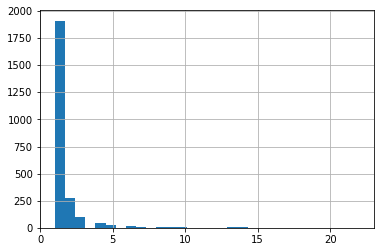

In [27]:
df.groupby(by=['Color','Next Color Code'],axis=0).nunique()['Cast Order'].hist(bins=30)

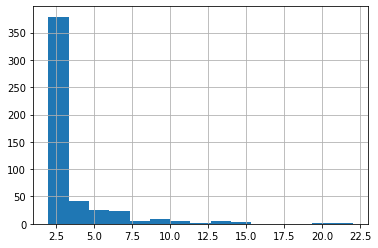

In [28]:
# if we filter for greater than 1 we get better resolution on the remaining data
df.groupby(by=['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 1)\
    .groupby(by=['Color','Next Color Code']).nunique()['Cast Order'].hist(bins=15)

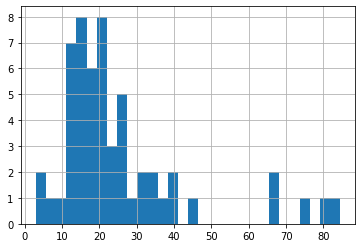

In [29]:
# the median transition sheets have a weibull distribution around 20
df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 5).\
    groupby(['Color','Next Color Code'])['Transition Sheets'].median().hist(bins=30)

In [30]:
# sort lowest to highest mean (range, max, min)
# process may be more uncertain -> results in higher mean/median

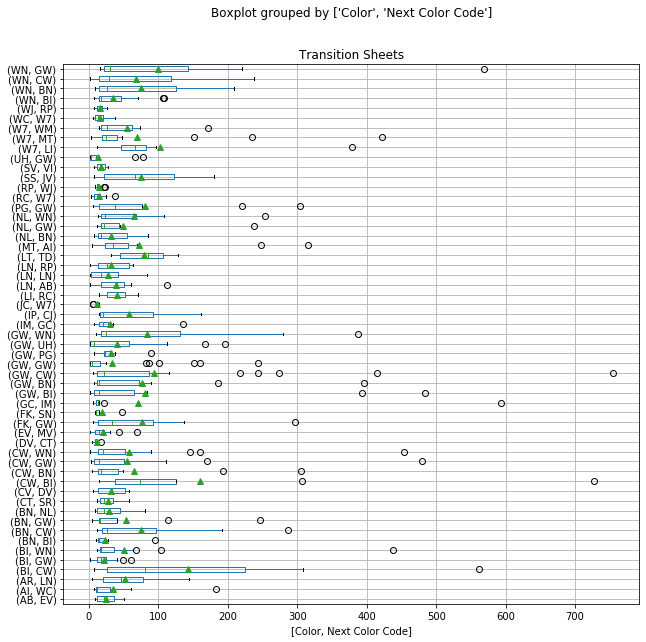

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 5)\
            .boxplot(by=['Color','Next Color Code'], column=['Transition Sheets'], 
                    figsize=(13,13), vert=False, showmeans=True, ax=ax)

In [32]:
fig.savefig('boxplot_subfamilies.png')

### transition matrix

In [33]:
tm = np.zeros((20,20))

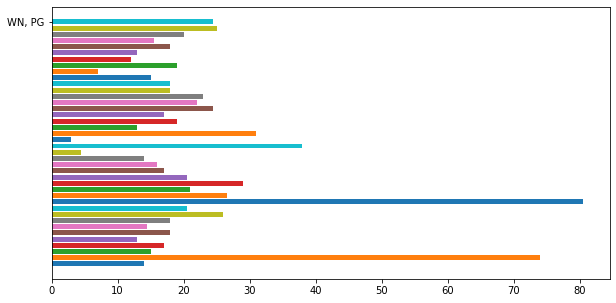

In [34]:
tac = 0
fig, ax = plt.subplots(1,1,figsize=(10,5))
test = df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 4)
# step = 0
for index, item in enumerate(test['Color'].unique()):
    for index2, item2 in enumerate(test.loc[test['Color'] == item]['Next Color Code'].unique()):
        if test.loc[(test['Color'] == item2) & (test['Next Color Code'] == item)].shape[0] != 0:
            ax.barh(tac, 
                    test.loc[(test['Color'] == item2) & (test['Next Color Code'] == item)]['Transition Sheets'].median(),
                   tick_label = '{}, {}'.format(item, item2))
#             plt.legend()
#             ax.set_xlabel('{}, {}'.format(item, item2))
#             print(item,item2)
#             tm[[]]
            tac += 1

<a id ='terminate'></a>

### terminating long transitions

[back to top](#top)

In [35]:
# subselect dataset based on number of transitions
# df = df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 6)
# df.reset_index(inplace=True)

In [36]:
# what is the IQR of two data points?
# df.loc[(df['Color'] == 'CL') & (df['Next Color Code'] == 'W5')].describe()

In [37]:
# product based transitions
tdf = df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 10)\
        .groupby(['Color','Next Color Code'])['Transition Sheets'].describe()
tdf.reset_index(inplace=True)

# family based transitions
tdff = dff.groupby(by=['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 10)\
        .groupby(by=['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
tdff.reset_index(inplace=True)

# pigment based transitions
tdfp = dff.groupby(['pigment_x', 'pigment_y']).filter(lambda g: g['Cast Order'].nunique() > 10)\
        .groupby(['pigment_x', 'pigment_y'])['Transition Sheets'].describe()
tdfp.reset_index(inplace=True)

In [38]:
# for [item] in schedule (the df we currently have)
# lookup median transition time for color A -> color B
# if past 1.5 * IQR + median then append(thrown_out)
# append(keep) median transition time of A -> random pairing
# else append(keep)
# if no A -> B data lookup family A -> famixly B, and repeat
# else if >250 throw_out
# for each action append(kept, product basis/family basis/250 or thrown out, product/fam/250)
df['Product Hit'] = 0
df['Family Hit'] = 0
df['Pigment Hit'] = 0
df['Thrown Out'] = 0
thrown_out = [] #tracks what we're throwing out
prod_coverage = 0 # tracks transition data coverage for each category
fam_coverage = 0
pig_coverage = 0
no_coverage = 0
for index in df.index: #index must be sequential
    covered = False
    current = pd.DataFrame(df.iloc[index]).T
    stats = pd.merge(tdf, current, how='inner', on=['Color', 'Next Color Code'])
    group_stats = pd.merge(dff, current, how='inner', on=['Color', 'Next Color Code'])
    if group_stats.shape[0] > 0:
        fam_stats = pd.merge(group_stats, tdff, how='inner', on=['sub_family_x', 'sub_family_y'])
        pig_stats = pd.merge(group_stats, tdfp, how='inner', on=['pigment_x', 'pigment_y'])
        if fam_stats.shape[0] > 0:
            if (fam_stats['sub_family_x'][0] == 'Genesis') & (fam_stats['sub_family_y'][0] == 'Genesis'):
                pass
    if stats.shape[0] > 0:
        cut_off = (stats['75%'] - stats['25%']) * 1.5 + stats['50%']
        prod_coverage += 1
        covered = True
        df['Product Hit'][index] = cut_off[0]
        if current['Transition Sheets'].values[0] > cut_off[0]:
            df['Thrown Out'][index] = cut_off[0]
            
            
    
    if group_stats.shape[0] > 0:
        fam_stats = pd.merge(group_stats, tdff, how='inner', on=['sub_family_x', 'sub_family_y'])
        if fam_stats.shape[0] > 0:
            cut_off = (fam_stats['75%'] - fam_stats['25%']) * 1.5 + fam_stats['50%']
            fam_coverage += 1
            covered = True
            df['Family Hit'][index] = cut_off[0]
            if current['Transition Sheets'].values[0] > cut_off[0]:
                if covered == False: #only throw out once
                    df['Thrown Out'][index] = cut_off[0]
                
        pig_stats = pd.merge(group_stats, tdfp, how='inner', on=['pigment_x', 'pigment_y'])
        if pig_stats.shape[0] > 0:
            cut_off = (pig_stats['75%'] - pig_stats['25%']) * 1.5 + pig_stats['50%']
            pig_coverage += 1
            covered = True
            df['Pigment Hit'][index] = cut_off[0]
            if current['Transition Sheets'].values[0] > cut_off[0]:
                if covered == False: #only throw out once
                    df['Thrown Out'][index] = cut_off[0]

                
    if covered == False:
        no_coverage += 1
    if (df['Thrown Out'][index] == 0) and (current['Transition Sheets'].values[0] >= 250):
        df['Thrown Out'][index] = 250

<ipython-input-38-2c06c299dbbb>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Family Hit'][index] = cut_off[0]
<ipython-input-38-2c06c299dbbb>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Thrown Out'][index] = 250
<ipython-input-38-2c06c299dbbb>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Product Hit'][index] = cut_off[0]
<ipython-input-38-2c06c299dbbb>:55: SettingWithCopyWarning: 
A value is trying to be set on

In [39]:
y = np.zeros((7))
y[0] = df.loc[df['Product Hit'] != 0].shape[0]
y[1] = df.loc[df['Family Hit'] != 0].shape[0]
# y[2] = df.loc[df['Pigment Hit'] != 0].shape[0]
y[2] = df.loc[(df['Family Hit'] != 0) & (df['Product Hit'] != 0)].shape[0]
# y[4] = df.loc[(df['Pigment Hit'] != 0) & (df['Family Hit'] != 0) & (df['Product Hit'] != 0)].shape[0]
y[3] = df.loc[(df['Product Hit'] != 0) & (df['Family Hit'] == 0)].shape[0]
y[4] = df.loc[(df['Product Hit'] == 0) & (df['Family Hit'] != 0)].shape[0]
y[5] = df.loc[(df['Family Hit'] != 0) | (df['Product Hit'] != 0)].shape[0]
y[6] = df.loc[(df['Family Hit'] == 0) & (df['Product Hit'] == 0)].shape[0]

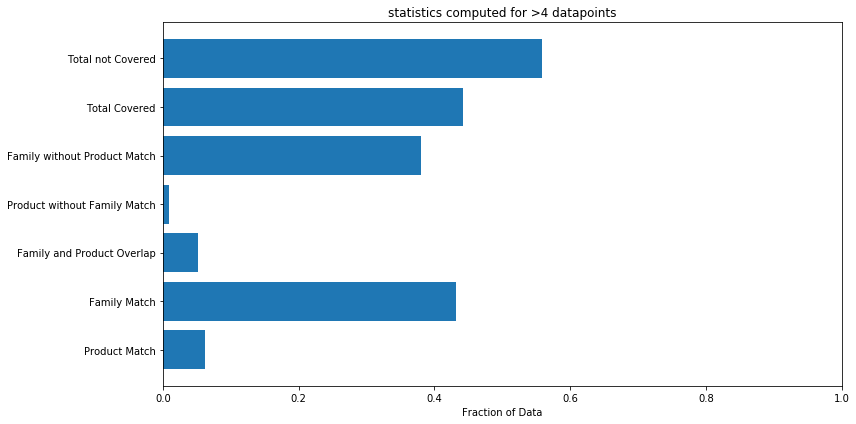

In [40]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
labels=['Product Match', 'Family Match', 
        'Family and Product Overlap',  
        'Product without Family Match', 
        'Family without Product Match', 
        'Total Covered', 
        'Total not Covered']
for index in range(len(y)):
    ax.barh(index,y[index]/df.shape[0],label=labels[index],color='tab:blue')
# ax.set_yticks(np.arange(len(y)),(labels))
plt.yticks(np.arange(len(y)),(labels))
ax.set_xlim(0,1)
ax.set_xlabel('Fraction of Data')
plt.title('statistics computed for >4 datapoints')
plt.tight_layout()
# ax.legend()

In [41]:
# fig, ax = plt.subplots(1,1,figsize=(10,10))
labels=['Product Match', 'Family Match', 
        'Family and Product Overlap',  
        'Product without Family Match', 
        'Family without Product Match', 
        'Total Covered', 
        'Total not Covered']
for index in range(len(y)):
    print(y[index]/df.shape[0])
    ax.barh(index,y[index]/df.shape[0],label=labels[index],color='tab:blue')

0.061589878252566246
0.43184530914299357
0.05204105991883504
0.009548818333731201
0.3798042492241585
0.44139412747672474
0.5586058725232752


In [42]:
# fig.savefig('explained_fraction_4_cutoff.png', dpi=300)

In [43]:
killed_jobs = df.loc[df['Thrown Out'] != 0]
# print(killed_jobs.shape[0])
saved_jobs = df.loc[df['Thrown Out'] == 0]
saved = (df['Transition Sheets'].mean() - saved_jobs['Transition Sheets'].mean()) / df['Transition Sheets'].mean()
print(saved_jobs.shape[0])
print('average transition sheets, entire dataset: {:.2f}'.format(df['Transition Sheets'].mean()))
print('average transition sheets, saved jobs: {:.2f}'.format(saved_jobs['Transition Sheets'].mean()))
print('percent transition sheet reduction: {:.1f}%'.format(saved*100))

df.shape[0]

4040
average transition sheets, entire dataset: 46.67
average transition sheets, saved jobs: 35.74
percent transition sheet reduction: 23.4%


4189

In [44]:
#how many agrade nans did we hit out of 
#the total dataset? how can we improve?
print('transitions producing no A grade sheets: {}'.format(df.loc[(df['AGrade Sheets'] < 1) | (df['AGrade Sheets'].isnull())].shape[0]))
print('transitions producing no A grade sheets after new SOP: {}'.format(saved_jobs.loc[(saved_jobs['AGrade Sheets'] < 1) | (saved_jobs['AGrade Sheets'].isnull())].shape[0]))

transitions producing no A grade sheets: 1657
transitions producing no A grade sheets after new SOP: 1598


In [45]:
sheets_saved = []
product_killed = 0
family_killed = 0
cutoff_killed = 0
for job in killed_jobs.index:
    if killed_jobs['Product Hit'][job] != 0:
        #save sheet is trans sheets - hit + mean of saved jobs (going to another transition)
        sheets_saved.append(killed_jobs['Transition Sheets'][job] - killed_jobs['Product Hit'][job] - saved_jobs['Transition Sheets'].mean())
        product_killed += 1
    elif killed_jobs['Family Hit'][job] != 0:
        #do same for fam, thrownout columns
        sheets_saved.append(killed_jobs['Transition Sheets'][job] - killed_jobs['Family Hit'][job] - saved_jobs['Transition Sheets'].mean())
        family_killed += 1
    elif killed_jobs['Thrown Out'][job] != 0:
        #do same for 250 hard cutoff
        sheets_saved.append(killed_jobs['Transition Sheets'][job] - killed_jobs['Thrown Out'][job] - saved_jobs['Transition Sheets'].mean())
        cutoff_killed += 1
print('product, family, and cutoff killed jobs: {}, {}, {}'.format(product_killed, family_killed, cutoff_killed))

product, family, and cutoff killed jobs: 40, 58, 51


In [46]:
np.sum(sheets_saved)

22249.078614762388

In [47]:
np.sum(sheets_saved) / df['Transition Sheets'].sum()

0.11613890587276071

In [48]:
sheets_saved_matrix = {
    '250 sheet abort': [16138, 11788],
    'IQR abort for >1 product/family grouping': [23638, 13508],
    'IQR abort for >2 product/family grouping': [28470, 19089],
    'IQR abort for >4 product/family grouping': [28780, 21743],
    'IQR abort for >6 product/family grouping': [27676, 21743],
    'IQR abort for >10 product/family grouping': [27575, 22249],
    'IQR abort for >12 product/family grouping': [26909, 21783]}
sheets_saved_matrix = pd.DataFrame(sheets_saved_matrix).T
sheets_saved_matrix.columns = ['saved', 'saved w/ mean subtract']

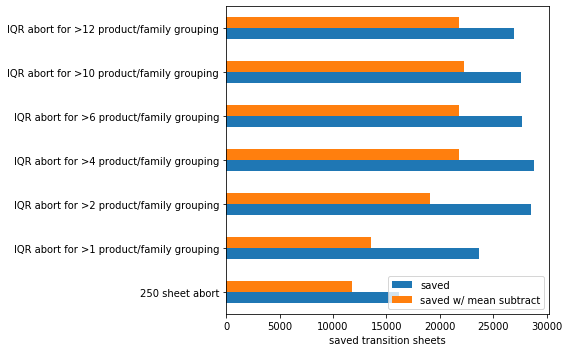

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
sheets_saved_matrix.plot.barh(ax=ax)
ax.set_xlabel('saved transition sheets')
plt.tight_layout()

In [50]:
# fig.savefig('assets/stat_criteria.png', dpi=300)

<a id='quadrants'></a>

### Quadrants

[back to top](#top)

Text(0, 0.5, 'mean')

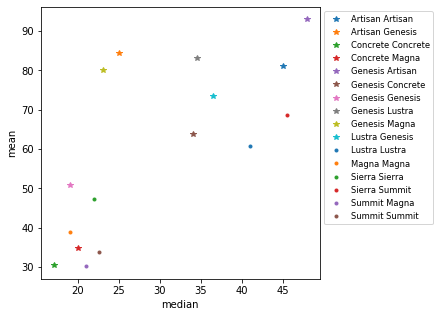

In [51]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 10).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
data.reset_index(inplace=True)
fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in range(data.shape[0]):
    if i > 9:
        ax.plot(data['50%'][i], data['mean'][i], ls='', marker='.',
            label=data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
    else:
        ax.plot(data['50%'][i], data['mean'][i], ls='', marker='*',
            label=data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
ax.legend(fontsize='small', bbox_to_anchor=(1,1))
ax.set_xlabel('median')
ax.set_ylabel('mean')

Text(0, 0.5, 'IQR')

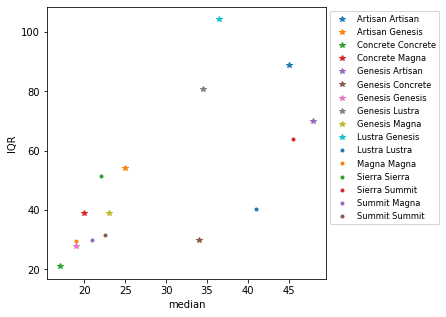

In [52]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 10).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
data.reset_index(inplace=True)
fig, ax = plt.subplots(1,1,figsize=(5,5))
for i in range(data.shape[0]):
    if i > 9:
        ax.plot(data['50%'][i], data['75%'][i] - data['25%'][i], ls='', marker='.',
            label=data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
    else:
        ax.plot(data['50%'][i], data['75%'][i] - data['25%'][i], ls='', marker='*',
            label=data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
ax.legend(fontsize='small', bbox_to_anchor=(1,1))
ax.set_xlabel('median')
ax.set_ylabel('IQR')

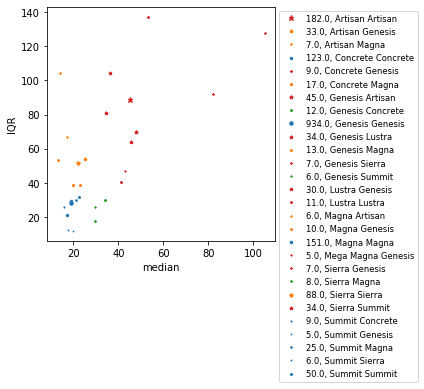

In [53]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 4).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
data.reset_index(inplace=True)
iqr_cutoff = 38
median_cutoff = 29
fig, ax = plt.subplots(1,1,figsize=(6,5))
for i in range(data.shape[0]):
    median = data['50%'][i]
    iqr = data['75%'][i] - data['25%'][i]
    if (median < median_cutoff) & (iqr < iqr_cutoff): #I quadrant
        ax.plot(median, iqr, ls='', marker='.', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i], c='tab:blue')
    elif (median < median_cutoff) & (iqr > iqr_cutoff): #II quadrant
        ax.plot(median, iqr, ls='', marker='*', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i], c='tab:orange')
    elif (median > median_cutoff) & (iqr < iqr_cutoff): #III quadrant
        ax.plot(median, iqr, ls='', marker='*', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i], c='tab:green')
    elif (median > median_cutoff) & (iqr > iqr_cutoff): #IV quadrant
        ax.plot(median, iqr, ls='', marker='*', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i], c='tab:red')
ax.legend(fontsize='small', bbox_to_anchor=(1,1))
ax.set_xlabel('median')
ax.set_ylabel('IQR')
plt.tight_layout()

In [55]:
# fig.savefig('assets/quadrant_colors.png', dpi=300)

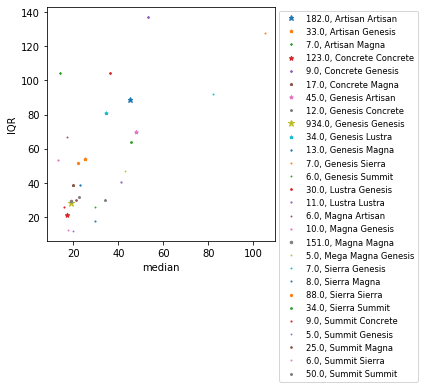

In [56]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 4).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
data.reset_index(inplace=True)
fig, ax = plt.subplots(1,1,figsize=(6,5))
for i in range(data.shape[0]):
    if i > 9:
        ax.plot(data['50%'][i], data['75%'][i] - data['25%'][i], ls='', marker='.', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
    else:
        ax.plot(data['50%'][i], data['75%'][i] - data['25%'][i], ls='', marker='*', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
ax.legend(fontsize='small', bbox_to_anchor=(1,1))
ax.set_xlabel('median')
ax.set_ylabel('IQR')
plt.tight_layout()

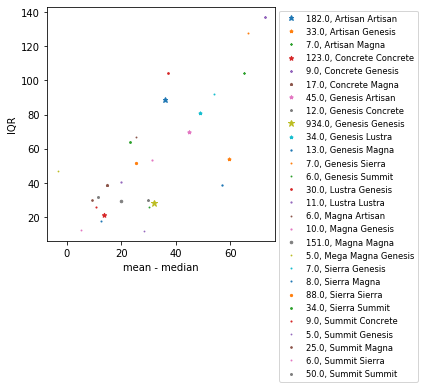

In [57]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 4).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
data.reset_index(inplace=True)
fig, ax = plt.subplots(1,1,figsize=(6,5))
for i in range(data.shape[0]):
    if i > 9:
        ax.plot(-data['50%'][i]+data['mean'][i], data['75%'][i] - data['25%'][i], ls='', marker='.', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
    else:
        ax.plot(-data['50%'][i]+data['mean'][i], data['75%'][i] - data['25%'][i], ls='', marker='*', ms=np.log(data['count'][i]),
            label= '{}, '.format(data['count'][i]) + data['sub_family_x'][i] + ' ' + data['sub_family_y'][i])
ax.legend(fontsize='small', bbox_to_anchor=(1,1))
ax.set_xlabel('mean - median')
ax.set_ylabel('IQR')
plt.tight_layout()

In [59]:
# fig.savefig('assets/quadrants_median.png', dpi=300)

Text(0, 0.5, 'IQR')

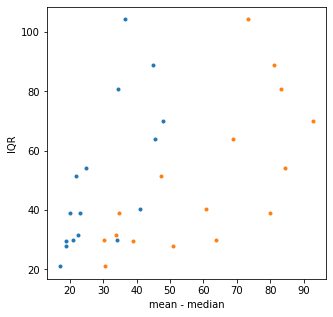

In [60]:
data = df2.groupby(['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 10).\
    groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(data['mean'] , data['75%'] - data['25%'], ls='', marker='.', c='tab:orange')
ax.plot(data['50%'], data['75%'] - data['25%'], ls='', marker='.', c='tab:blue')
ax.set_xlabel('mean - median')
ax.set_ylabel('IQR')

<a id='sorted'></a>

### Sorted box plots

[back to top](#top)

In [61]:
# inner merge with main dataframe
df2 = df.groupby(['Color', 'Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 0)
df2 = pd.merge(df2, family_df, how='inner', on='Color')
family_df.columns = ['Next Color Code','family','sub_family','pigment']
df2 = pd.merge(df2, family_df, how='inner', on='Next Color Code')
family_df.columns = ['Color','family','sub_family','pigment']

In [62]:
sorted_sheets = {}
for item in df2['Color'].unique():
    for item2 in df2.loc[df2['Color'] == item]['Next Color Code'].unique():
        data = df2.loc[(df2['Color'] == item) & (df2['Next Color Code'] == item2)]['Transition Sheets'].dropna()
        sorted_sheets['{}, {}'.format(item, item2)] = data.median()
sorted_sheets = pd.DataFrame(sorted_sheets,index=[0]).T
sorted_sheets.columns = ['Transition Sheets']

In [63]:
sorted_sheets.sort_values(by=['Transition Sheets'], inplace = True)

In [64]:
index_list = []
for index in sorted_sheets.index:
    sub_sel = df2.loc[(df2['Color'] == index.split(", ")[0]) & (df2['Next Color Code'] == index.split(", ")[1])]
    for item in sub_sel.index.values:
        index_list.append(item)

In [65]:
df2 = df2.iloc[index_list].reset_index(drop=True)#, inplace=True)

In [66]:
df2['Pairs'] = df2['Color'] + ' '+ df2['Next Color Code']
df2['Family Pairs'] = df2['sub_family_x'] + ' ' + df2['sub_family_y']

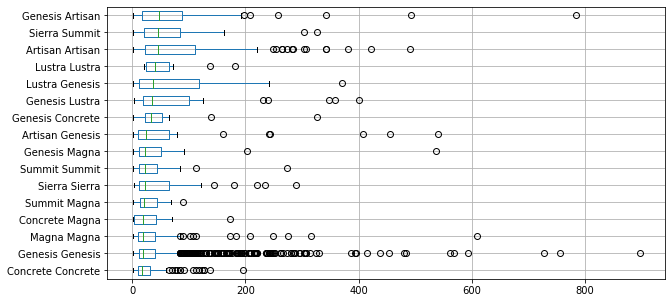

In [67]:
# genesis has a significant number of transitions outside 1.5 IQR
# but its also the subfamily we have the most data for
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.rcdefaults()
# plot = df2.loc[df2['Thrown Out'] != 0]
plot = df2.groupby('Family Pairs').filter(lambda g: g['Cast Order'].nunique() > 10)
boxplot_sorted(plot, by='Family Pairs', column='Transition Sheets')
# fig, ax = plt.subplots(1,1,figsize=(10,20))
# boxplot_sorted(plot, by='Pairs', column='Transition Sheets')
#                     vert=False, showmeans=True, ax=ax)
# plt.tight_layout()

In [68]:
df2.groupby('Family Pairs')["Transition Sheets"].describe().to_excel('family_transitions.xlsx')

In [69]:
# fig.savefig('assets/thrown_out_iqr.png', dpi=300)

/home/wab665/anaconda3/envs/py37/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


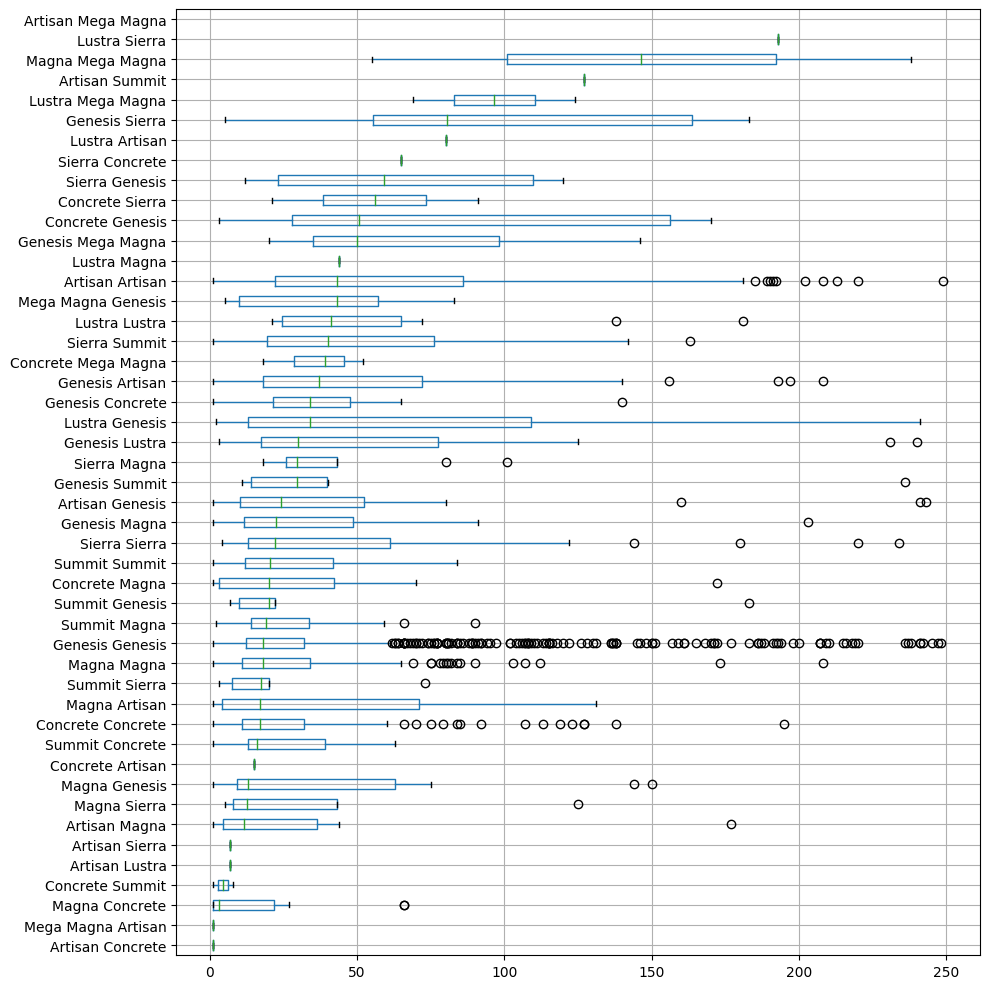

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
boxplot_sorted(df2.loc[df2['Thrown Out'] == 0], by='Family Pairs', column='Transition Sheets')
plt.tight_layout()

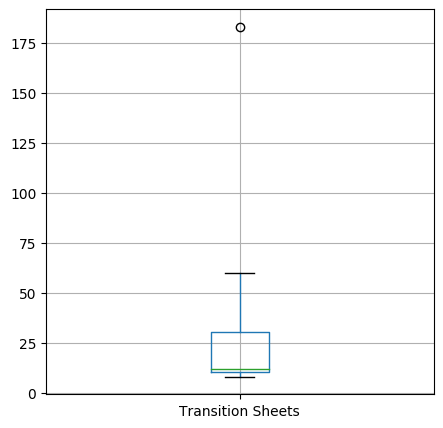

In [71]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
df2.loc[(df2['Color'] == 'AI') & (df2['Next Color Code'] == 'WC')].boxplot(column=['Transition Sheets'],ax=ax)
# df2.boxplot(column=['Transition Sheets'],ax=ax)

/home/wab665/anaconda3/envs/py37/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


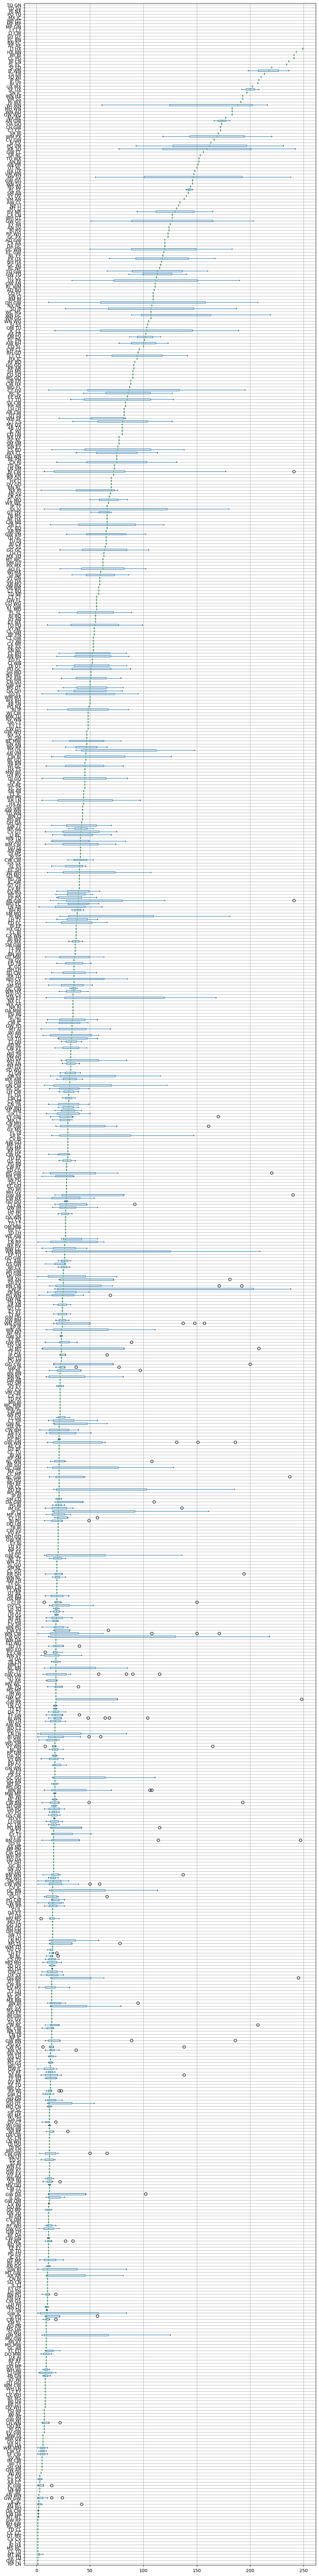

In [72]:
fig, ax = plt.subplots(1,1,figsize=(10,80))
boxplot_sorted(df2.loc[df2['Thrown Out'] == 0], by='Pairs', column='Transition Sheets')
plt.tight_layout()

In [73]:
fig.savefig('dist_after_throw_out.png', dpi=300)

In [74]:
# df.groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() > 3)\
#     .groupby(['Color','Next Color Code']).filter(lambda g: g['Cast Order'].nunique() < 6)\
#             .groupby(['Color','Next Color Code'])['Transition Sheets'].describe().to_csv('for_alan.csv')

<a id='transits'></a>

### median transition sheets vs number of transits

[back to top](#top)

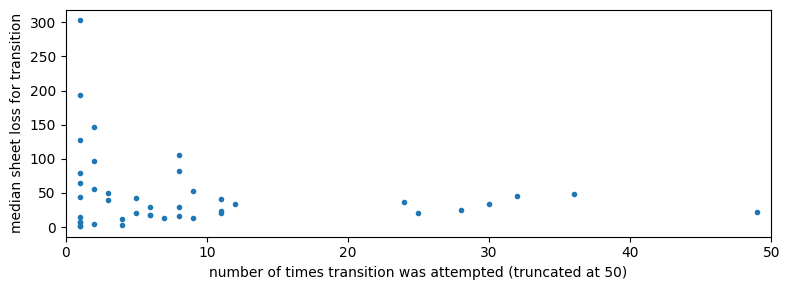

In [75]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
plt.rcdefaults()
ax.plot((dff.groupby(['sub_family_x', 'sub_family_y'])['Cast Order'].nunique()),
        dff.groupby(['sub_family_x', 'sub_family_y'])['Transition Sheets'].median(),
        ls='', marker='.')
ax.set_ylabel('median sheet loss for transition')
ax.set_xlabel('number of times transition was attempted (truncated at 50)')
ax.set_xlim(0,50)
plt.tight_layout()

In [77]:
# fig.savefig('assets/family_transitions.png', dpi=300)

Text(0.5, 36.72222222222221, 'number of times transition was attempted')

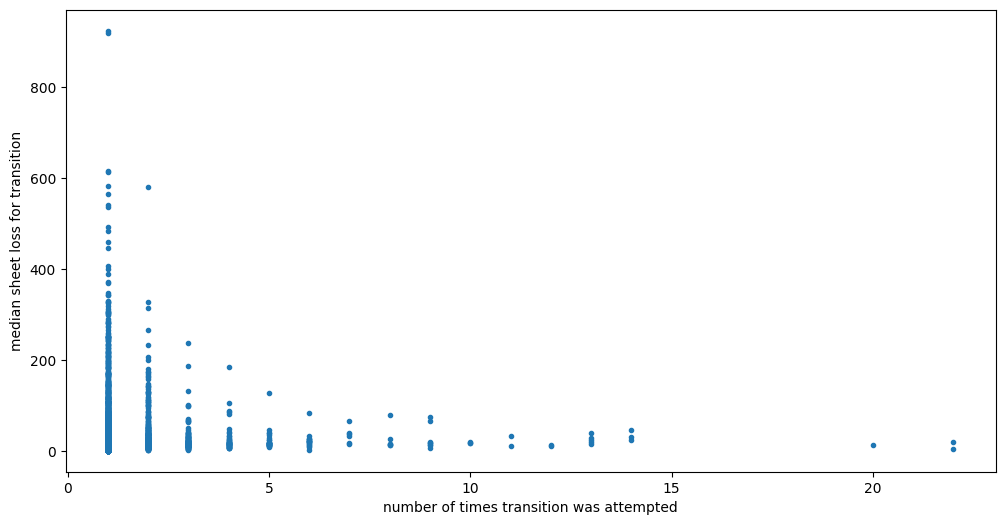

In [78]:
fig, ax = plt.subplots(1,1,figsize=(12,6))
plt.rcdefaults()
ax.plot(df.groupby(['Color', 'Next Color Code'])['Cast Order'].nunique(),
        df.groupby(['Color', 'Next Color Code'])['Transition Sheets'].median(),
        ls='', marker='.')
ax.set_ylabel('median sheet loss for transition')
ax.set_xlabel('number of times transition was attempted')

In [79]:
fig.savefig('loss_vs_attempts.png', dpi=300)

<a id='combinations'></a>

### data set combinations

[back to top](#top)

Adding family, subfamily, and colors 'pigments' to the dataset

Genesis seems to be a trouble maker

In [80]:
# most transitions are occuring within the same family
dff.groupby(by=['family_x', 'family_y'])['Transition Sheets'].describe()

count       mean         std  min   25%   50%    75%  \
family_x family_y                                                          
Granite  Granite    716.0  48.425978   64.033460  1.0  13.0  24.0  57.00   
         Standard    64.0  85.328125  133.181944  1.0  10.0  32.5  82.25   
Standard Granite     88.0  92.875000  136.756837  1.0  20.0  48.0  98.25   
         Standard  1038.0  53.736031   89.005464  1.0  13.0  20.0  47.75   

                     max  
family_x family_y         
Granite  Granite   609.0  
         Standard  565.0  
Standard Granite   784.0  
         Standard  897.0

In [81]:
fig.savefig('kde_subfamilies.png', dpi=300)

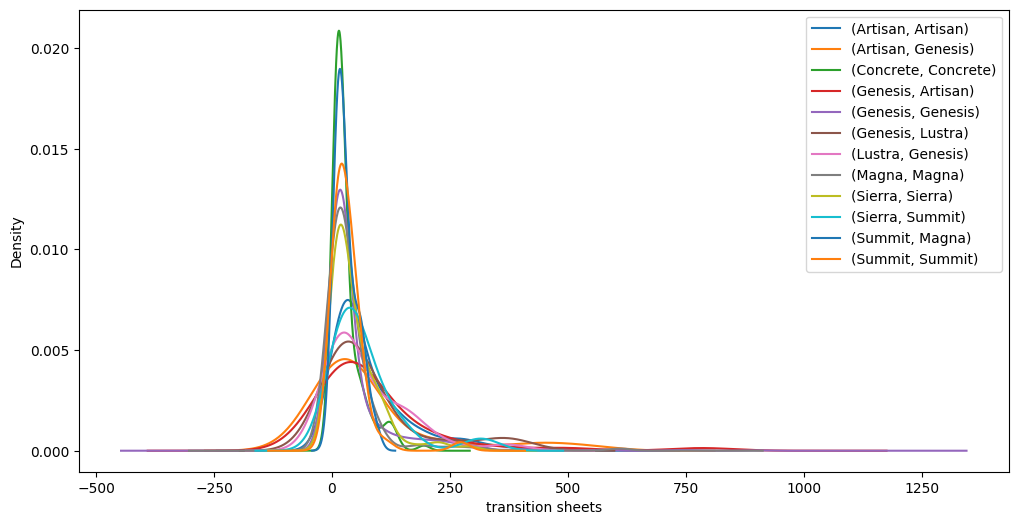

In [82]:
# genesis has a significant number of transitions outside 1.5 IQR
# but its also the subfamily we have the most data for
fig, ax = plt.subplots(1,1,figsize=(12,6))
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['tab:red', 'tab:green', 'tab:blue', 'tab:purple', 'tab:grey', 'tab:orange']) *
                           cycler('linestyle', ['-', '--', ':', '-.'])))
dff.groupby(by=['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 15)\
        .groupby(by=['sub_family_x', 'sub_family_y'])['Transition Sheets'].plot.kde(ax=ax)
ax.set_xlabel('transition sheets')
plt.legend()
# plt.tight_layout()

In [83]:
dff.head()

Cast Order Color  Next Cast Order Next Color Code          Cast Start  \
0    11528319    3D         11530682              CW 2017-03-09 18:22:00   
1    12661978    3D         12665266              CW 2018-08-26 18:10:00   
2    11617183    AR         11622902              CW 2018-02-21 22:45:00   
3    11504211    BI         11504231              CW 2017-01-09 17:46:00   
4    11504211    BI         11504231              CW 2017-01-10 00:01:00   

        Cast End Time  Total Sheets  AGrade Sheets  Transition Sheets  \
0 2017-03-09 19:15:00         108.0           93.0               14.0   
1 2018-08-27 06:14:00         942.0          557.0               56.0   
2 2018-02-22 00:57:00         181.0          105.0               82.0   
3 2017-01-09 19:52:00         300.0            NaN              308.0   
4 2017-01-10 06:18:00         912.0          840.0               10.0   

   family_x sub_family_x pigment_x  family_y sub_family_y    pigment_y  
0  Standard      Genesis      Clay  Standard      Genesis  CAMEO WHITE  
1  Standard      Genesis      Clay  Standard      Genesis  CAMEO WHITE  
2   Granite       Sierra    Aurora  Standard      Genesis  CAMEO WHITE  
3  Standard      Genesis    BISQUE  Standard      Genesis  CAMEO WHITE  
4  Standard      Genesis    BISQUE  Standard      Genesis  CAMEO WHITE

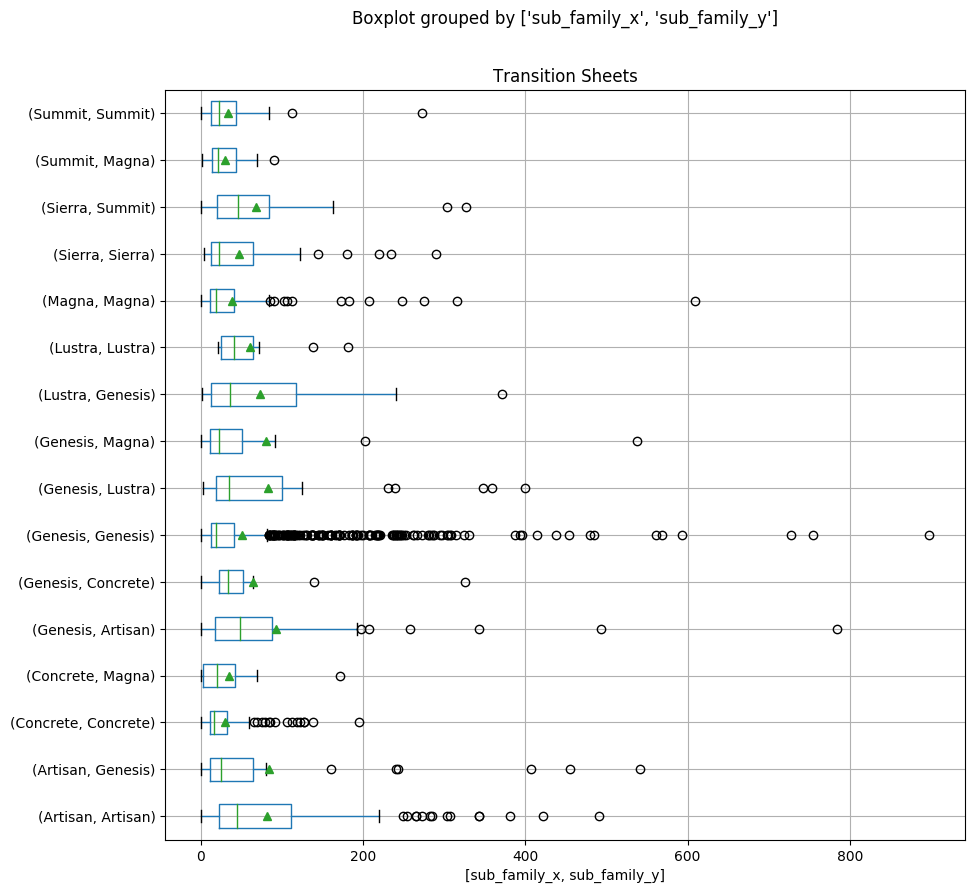

In [84]:
# genesis has a significant number of transitions outside 1.5 IQR
# but its also the subfamily we have the most data for
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcdefaults()
dff.groupby(by=['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 10)\
        .boxplot(by=['sub_family_x', 'sub_family_y'], column=['Transition Sheets'],
                    vert=False, showmeans=True, ax=ax)
# plt.tight_layout()

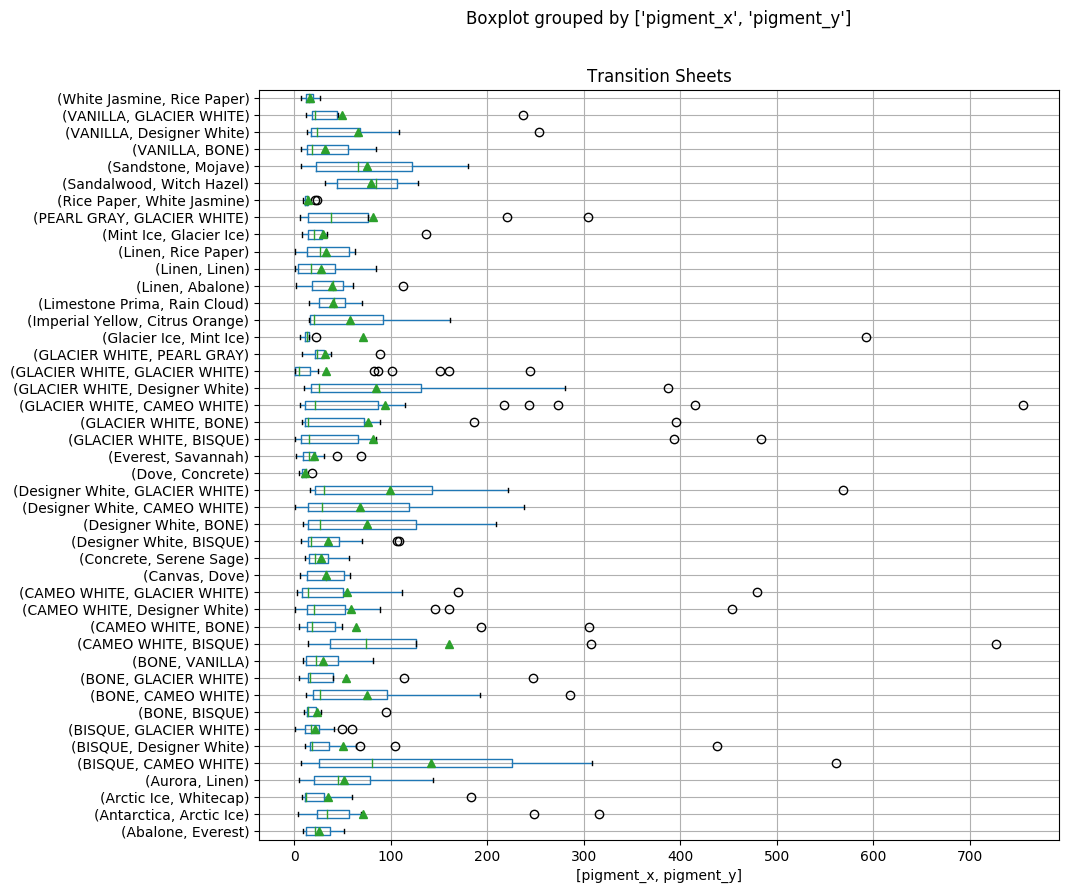

In [85]:
# genesis has a significant number of transitions outside 1.5 IQR
# but its also the subfamily we have the most data for
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcdefaults()
dff.groupby(['pigment_x', 'pigment_y']).filter(lambda g: g['Cast Order'].nunique() > 5)\
            .boxplot(by=['pigment_x', 'pigment_y'], column=['Transition Sheets'],
                    vert=False, showmeans=True, ax=ax)

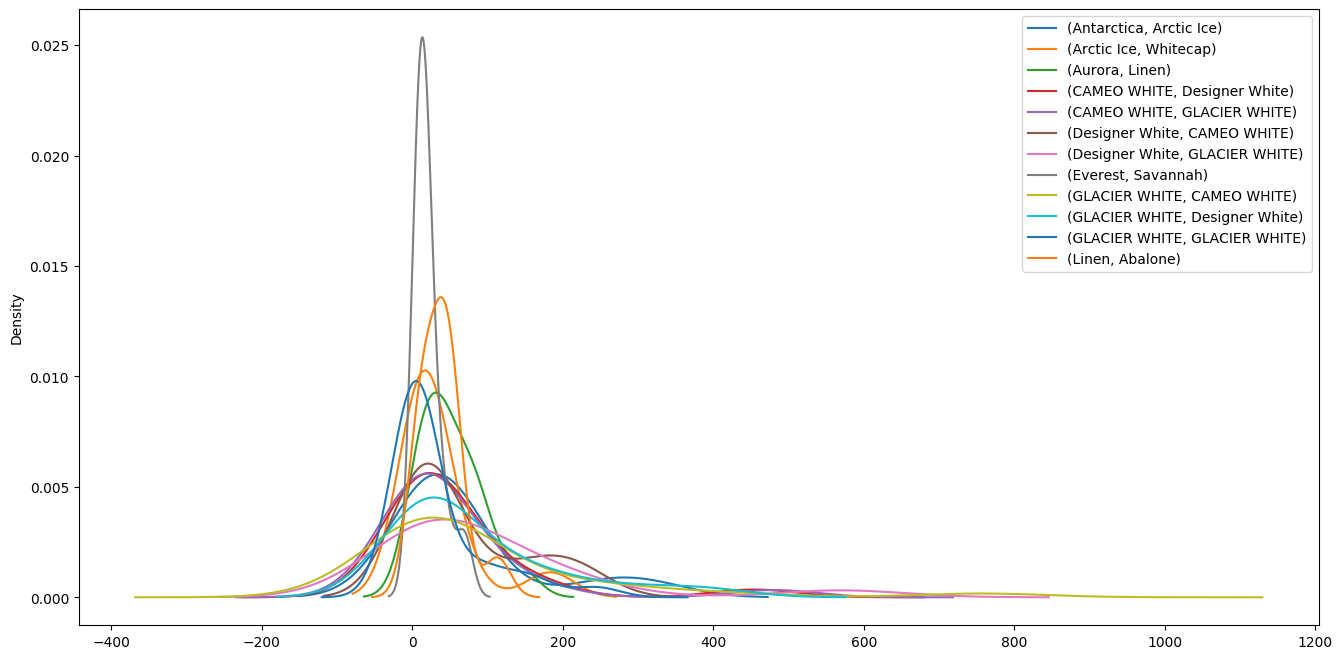

In [86]:
# genesis has a significant number of transitions outside 1.5 IQR
# but its also the subfamily we have the most data for
fig, ax = plt.subplots(1,1,figsize=(16,8))
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler('color', ['tab:red', 'tab:green', 'tab:blue', 'tab:purple', 'tab:grey', 'tab:orange']) *
                           cycler('linestyle', ['-', '--', ':', '-.'])))
dff.groupby(by=['pigment_x', 'pigment_y']).filter(lambda g: g['Cast Order'].nunique() > 10)\
        .groupby(by=['pigment_x', 'pigment_y'])['Transition Sheets'].plot.kde(ax=ax)
plt.legend()
# plt.tight_layout()

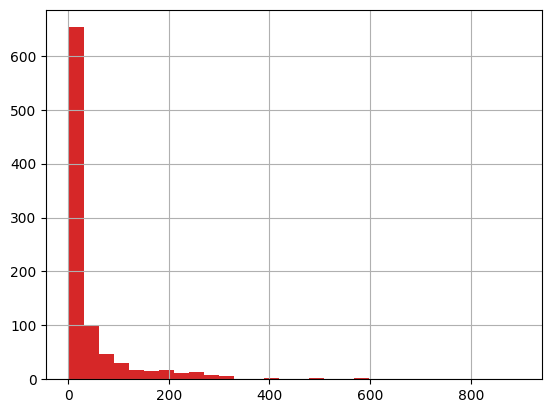

In [87]:
dff.loc[(dff['sub_family_x'] == 'Genesis') & (dff['sub_family_y'] == 'Genesis')]['Transition Sheets'].hist(bins=30)

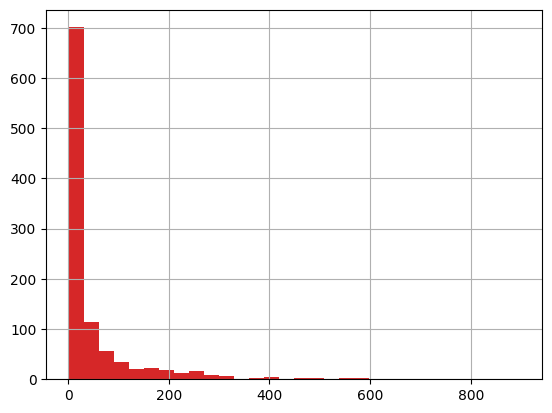

In [88]:
dff.loc[(dff['sub_family_y'] == 'Genesis')]['Transition Sheets'].hist(bins=30)

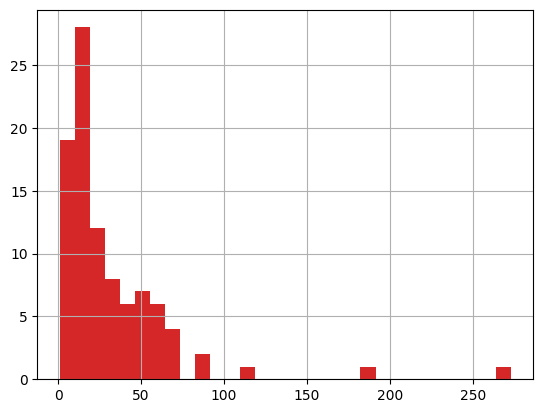

In [89]:
dff.loc[(dff['sub_family_x'] == 'Summit')]['Transition Sheets'].hist(bins=30)

In [90]:
fig.savefig('subfamily_count.png')

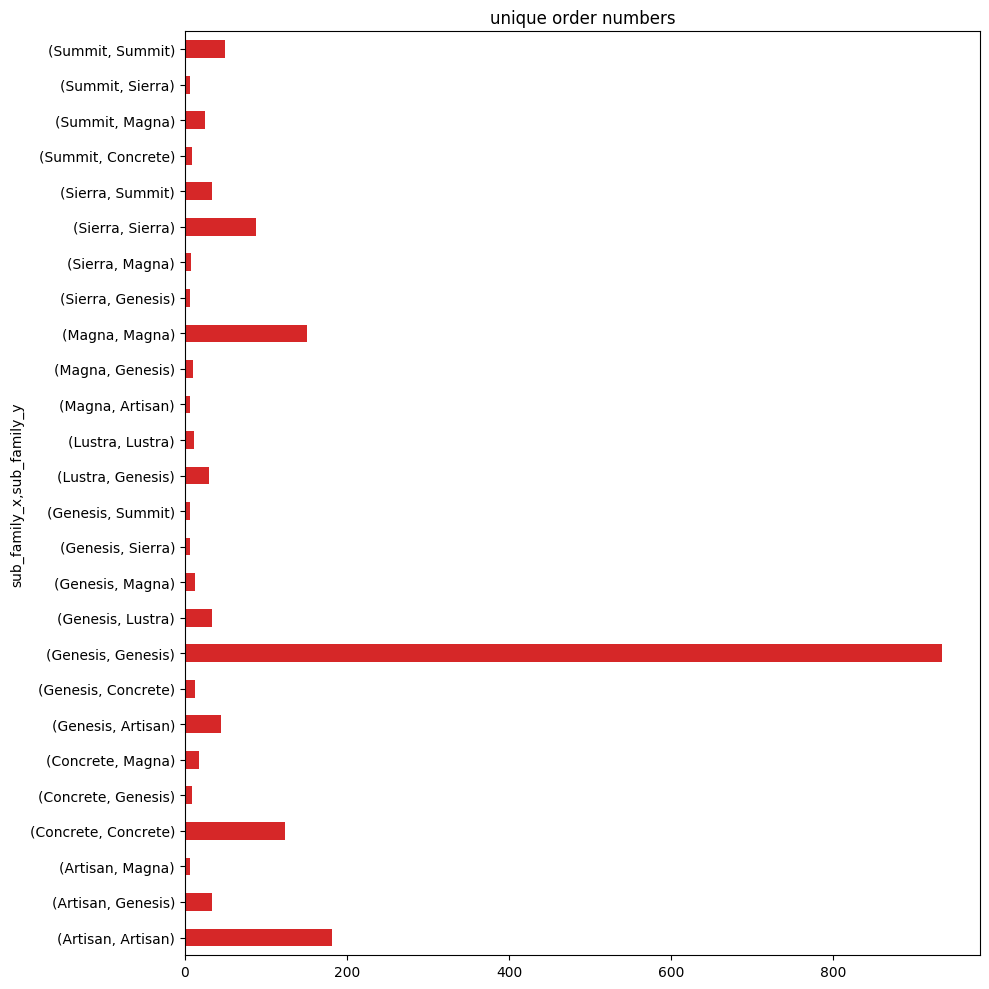

In [91]:
fig, ax = plt.subplots(1,1)
dff.groupby(by=['sub_family_x', 'sub_family_y']).filter(lambda g: g['Cast Order'].nunique() > 5)\
                .groupby(by=['sub_family_x', 'sub_family_y'])['Transition Sheets'].\
                describe()['count'].plot.barh(figsize=(10,10), title='unique order numbers', ax=ax)
plt.tight_layout()

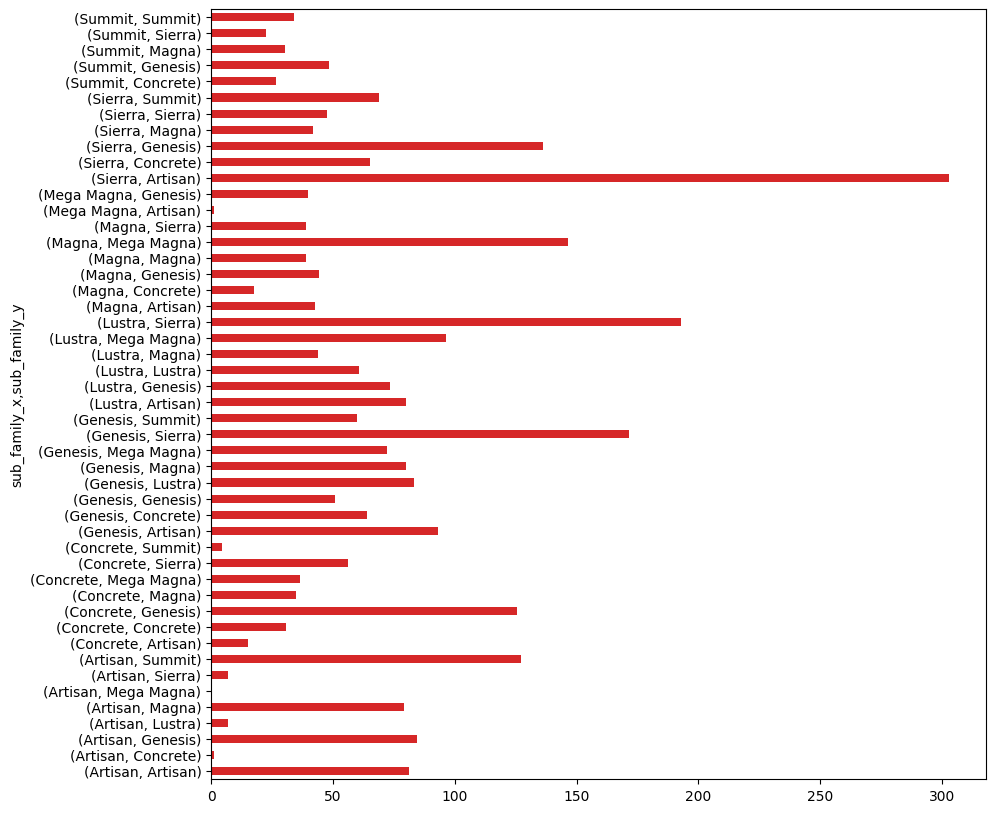

In [92]:
dff.groupby(by=['sub_family_x', 'sub_family_y'])['Transition Sheets'].describe()['mean'].plot.barh(figsize=(10,10))

In [93]:
dff.columns

Index(['Cast Order', 'Color', 'Next Cast Order', 'Next Color Code',
       'Cast Start', 'Cast End Time', 'Total Sheets', 'AGrade Sheets',
       'Transition Sheets', 'family_x', 'sub_family_x', 'pigment_x',
       'family_y', 'sub_family_y', 'pigment_y'],
      dtype='object')

In [94]:
# dff.groupby(by=['pigment_x', 'pigment_y'])['Transition Sheets'].describe()

[back to top](#top)